In [68]:
import glob as glob
import pandas as pd
import polars as pl
import seaborn as sns
from __future__ import annotations

import gzip
from operator import itemgetter
from typing import Literal, Optional, Sequence, Union

import numpy as np
import pandas as pd
import polars as pl
import pyarrow as pa
import pyarrow.csv
import pyranges as pr

import matplotlib.pyplot as plt

# from pycisTopic.utils import format_path


%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [2]:
fragments_path_dict = {
    x.split("/")[-1].split(".fragments")[0]: x
    for x in sorted(
        glob.glob("../1_data_repository/fixedcells_fragments/*.fragments.tsv.gz")
    )
}
fragments_path_dict

{'BIO_ddseq_1.FIXEDCELLS': '../1_data_repository/fixedcells_fragments/BIO_ddseq_1.FIXEDCELLS.fragments.tsv.gz',
 'BIO_ddseq_2.FIXEDCELLS': '../1_data_repository/fixedcells_fragments/BIO_ddseq_2.FIXEDCELLS.fragments.tsv.gz',
 'BIO_ddseq_3.FIXEDCELLS': '../1_data_repository/fixedcells_fragments/BIO_ddseq_3.FIXEDCELLS.fragments.tsv.gz',
 'BIO_ddseq_4.FIXEDCELLS': '../1_data_repository/fixedcells_fragments/BIO_ddseq_4.FIXEDCELLS.fragments.tsv.gz',
 'BRO_mtscatac_1.FIXEDCELLS': '../1_data_repository/fixedcells_fragments/BRO_mtscatac_1.FIXEDCELLS.fragments.tsv.gz',
 'BRO_mtscatac_2.FIXEDCELLS': '../1_data_repository/fixedcells_fragments/BRO_mtscatac_2.FIXEDCELLS.fragments.tsv.gz',
 'CNA_10xmultiome_1.FIXEDCELLS': '../1_data_repository/fixedcells_fragments/CNA_10xmultiome_1.FIXEDCELLS.fragments.tsv.gz',
 'CNA_10xmultiome_2.FIXEDCELLS': '../1_data_repository/fixedcells_fragments/CNA_10xmultiome_2.FIXEDCELLS.fragments.tsv.gz',
 'CNA_10xv11_1.FIXEDCELLS': '../1_data_repository/fixedcells_fragmen

In [3]:
metadata_path_dict = {
    x.split("/")[-1].split("__")[0]: x
    for x in sorted(glob.glob("cistopic_objects/*.consensus.cell_data.tsv"))
}
metadata_path_dict

{'BIO_ddseq_1.FIXEDCELLS': 'cistopic_objects/BIO_ddseq_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_11topics.dimreduc.consensus.cell_data.tsv',
 'BIO_ddseq_2.FIXEDCELLS': 'cistopic_objects/BIO_ddseq_2.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_14topics.dimreduc.consensus.cell_data.tsv',
 'BIO_ddseq_3.FIXEDCELLS': 'cistopic_objects/BIO_ddseq_3.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_10topics.dimreduc.consensus.cell_data.tsv',
 'BIO_ddseq_4.FIXEDCELLS': 'cistopic_objects/BIO_ddseq_4.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_11topics.dimreduc.consensus.cell_data.tsv',
 'BRO_mtscatac_1.FIXEDCELLS': 'cistopic_objects/BRO_mtscatac_1.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_11topics.dimreduc.consensus.cell_data.tsv',
 'BRO_mtscatac_2.FIXEDCELLS': 'cistopic_objects/BRO_mtscatac_2.FIXEDCELLS__cto.scrublet0-4.fmx.singlets.model_17topics.dimreduc.consensus.cell_data.tsv',
 'CNA_10xmultiome_1.FIXEDCELLS': 'cistopic_objects/CNA_10xmultiome_1.FIXEDCELLS__cto.scrublet0-4.fmx

In [4]:
import os

In [5]:
def read_bed_to_polars_df(
    bed_filename: str,
    engine: str | Literal["polars"] | Literal["pyarrow"] = "pyarrow",
    min_column_count: int = 3,
) -> pl.DataFrame:
    """
    Read BED file to a Polars DataFrame.
    Parameters
    ----------
    bed_filename
        BED filename.
    engine
        Use Polars or pyarrow to read the BED file (default: pyarrow).
    min_column_count
        Minimum number of required columns needed in BED file.
    Returns
    -------
    Polars DataFrame with BED entries.
    Examples
    --------
    Read BED file to Polars DataFrame with pyarrow engine.
    >>> bed_df_pl = read_bed_to_polars_df("test.bed", engine="pyarrow")
    Read BED file to Polars DataFrame with pyarrow engine and require that the BED file has at least 4 columns.
    >>> bed_with_at_least_4_columns_df_pl = read_bed_to_polars_df("test.bed", engine="pyarrow", min_column_count=4)
    """

    bed_column_names = (
        "Chromosome",
        "Start",
        "End",
        "Name",
        "Score",
        "Strand",
        "ThickStart",
        "ThickEnd",
        "ItemRGB",
        "BlockCount",
        "BlockSizes",
        "BlockStarts",
    )

    bed_filename = format_path(bed_filename)

    # Set the correct open function, depending upon if the fragments BED file is gzip compressed or not.
    open_fn = gzip.open if bed_filename.endswith(".gz") else open

    skip_rows = 0
    column_count = 0
    with open_fn(bed_filename, "rt") as bed_fh:
        for line in bed_fh:
            # Remove newlines and spaces.
            line = line.strip()

            if not line or line.startswith("#"):
                # Count number of empty lines and lines which start with a comment before the actual data.
                skip_rows += 1
            else:
                # Get number of columns from the first real BED entry.
                column_count = len(line.split("\t"))

                # Stop reading the BED file.
                break

    if column_count < min_column_count:
        raise ValueError(
            f"BED file needs to have at least {min_column_count} columns. "
            f'"{bed_filename}" contains only {column_count} columns.'
        )

    # Set global string cache so categorical columns from multiple Polars DataFrames can be joined later, if necessary.
    pl.Config.set_global_string_cache()

    if engine == "polars":
        # Read BED file with Polars.
        bed_df_pl = pl.read_csv(
            bed_filename,
            has_header=False,
            skip_rows=skip_rows,
            sep="\t",
            use_pyarrow=False,
            new_columns=bed_column_names[:column_count],
            dtypes={
                "Chromosome": pl.Categorical,
                "Start": pl.Int32,
                "End": pl.Int32,
                "Name": pl.Categorical,
                "Strand": pl.Categorical,
            },
        )
    elif engine == "pyarrow":
        # Read BED file with pyarrow.
        bed_df_pl = pl.from_arrow(
            pa.csv.read_csv(
                bed_filename,
                read_options=pa.csv.ReadOptions(
                    use_threads=True,
                    skip_rows=skip_rows,
                    column_names=bed_column_names[:column_count],
                ),
                parse_options=pa.csv.ParseOptions(
                    delimiter="\t",
                    quote_char=False,
                    escape_char=False,
                    newlines_in_values=False,
                ),
                convert_options=pa.csv.ConvertOptions(
                    column_types={
                        "Chromosome": pa.dictionary(pa.int32(), pa.large_string()),
                        "Start": pa.int32(),
                        "End": pa.int32(),
                        "Name": pa.dictionary(pa.int32(), pa.large_string()),
                        "Strand": pa.dictionary(pa.int32(), pa.large_string()),
                    },
                ),
            )
        )
    else:
        raise ValueError(
            f'Unsupported engine value "{engine}" (allowed: ["polars", "pyarrow"]).'
        )

    return bed_df_pl


def read_fragments_to_polars_df(
    fragments_bed_filename: str,
    engine: str | Literal["polars"] | Literal["pyarrow"] = "pyarrow",
) -> pl.DataFrame:
    """
    Read fragments BED file to a Polars DataFrame.
    If fragments don't have a Score column, a Score columns is created by counting
    the number of fragments with the same chromosome, start, end and CB.
    Parameters
    ----------
    fragments_bed_filename
        Fragments BED filename.
    engine
        Use Polars or pyarrow to read the fragments BED file (default: pyarrow).
    Returns
    -------
    Polars DataFrame with fragments.
    Examples
    --------
    Read gzipped fragments BED file to a Polars DataFrame.
    >>> fragments_df_pl = read_fragments_to_polars_df(fragments_bed_filename="fragments.tsv.gz")
    Read uncompressed fragments BED file to a Polars DataFrame.
    >>> fragments_df_pl = read_fragments_to_polars_df(fragments_bed_filename="fragments.tsv")
    """

    fragments_df_pl = read_bed_to_polars_df(
        bed_filename=fragments_bed_filename,
        engine=engine,
        min_column_count=4,
    )

    # If no score is provided or score column is ".", generate a score column with the number of fragments which have
    # the same chromosome, start, end and CB.
    if (
        "Score" not in fragments_df_pl.columns
        or fragments_df_pl.schema["Score"] == pl.Utf8
    ):
        fragments_df_pl = fragments_df_pl.groupby(
            ["Chromosome", "Start", "End", "Name"]
        ).agg(pl.count().cast(pl.Int32()).alias("Score"))
    else:
        fragments_df_pl = fragments_df_pl.with_column(pl.col("Score").cast(pl.Int32()))

    return fragments_df_pl


def format_path(path: str | Path) -> str:
    """
    Create a string path, expanding the home directory if present.
    """

    return os.path.expanduser(path)

In [12]:
pl.Config.set_global_string_cache()

# initialize df
samplea_counts = pl.DataFrame(columns=[("Chromosome", pl.Categorical)])
sampleb_counts = pl.DataFrame(columns=[("Chromosome", pl.Categorical)])

# iterate over samples
for sample, path in metadata_path_dict.items():
    # for sample, path in [list(metadata_path_dict.items())[9]]:
    # read metadata
    metadata = pd.read_csv(path, index_col=0)

    # add raw bc column
    if "VIB_hydrop" in sample:
        metadata["raw_bc"] = [
            x.split("__")[0] + "-" + x.split("__")[1][13] for x in metadata.index
        ]
    else:
        metadata["raw_bc"] = [x.split("__")[0] for x in metadata.index]

    # if it is an fmx sample, do the following:
    if "fmx_sample" in metadata.columns:
        print(sample)
        fragments_df = read_fragments_to_polars_df(fragments_path_dict[sample])

        # get the barcodes for each of the 2 donors (sample a and b)
        samplea_barcodes = list(metadata[metadata["fmx_sample"] == "sampleA"]["raw_bc"])
        sampleb_barcodes = list(metadata[metadata["fmx_sample"] == "sampleB"]["raw_bc"])

        # for each donor, get a distribution of fragments on chromosomes
        df_counts_per_chrom_samplea = (
            fragments_df.filter(
                pl.col("Name").is_in(samplea_barcodes)
            )  # input barcodes here
            .groupby(["Chromosome", "Start", "End", "Name"])
            .agg(
                [
                    pl.col("Chromosome").first().alias("temp"),
                ]
            )
            .groupby("Chromosome")
            .agg(pl.count().alias(f"{sample}_samplea"))
            .sort(by="Chromosome")
        )

        df_counts_per_chrom_sampleb = (
            fragments_df.filter(pl.col("Name").is_in(sampleb_barcodes))
            .groupby(["Chromosome", "Start", "End", "Name"])
            .agg(
                [
                    pl.col("Chromosome").first().alias("temp"),
                ]
            )
            .groupby("Chromosome")
            .agg(pl.count().alias(f"{sample}_sampleb"))
            .sort(by="Chromosome")
        )

        # append these counts to the dataframe
        samplea_counts = samplea_counts.join(
            df_counts_per_chrom_samplea,
            on="Chromosome",
            how="outer",
        )

        sampleb_counts = sampleb_counts.join(
            df_counts_per_chrom_sampleb,
            on="Chromosome",
            how="outer",
        )

BRO_mtscatac_1.FIXEDCELLS
BRO_mtscatac_2.FIXEDCELLS
CNA_10xmultiome_1.FIXEDCELLS
CNA_10xmultiome_2.FIXEDCELLS
CNA_10xv11_1.FIXEDCELLS
CNA_10xv11_2.FIXEDCELLS
CNA_10xv11_3.FIXEDCELLS
CNA_10xv11_4.FIXEDCELLS
CNA_10xv11_5.FIXEDCELLS
CNA_10xv2_1.FIXEDCELLS
CNA_10xv2_2.FIXEDCELLS
CNA_hydrop_1.FIXEDCELLS
CNA_hydrop_2.FIXEDCELLS
CNA_hydrop_3.FIXEDCELLS
CNA_mtscatac_1.FIXEDCELLS
CNA_mtscatac_2.FIXEDCELLS
EPF_hydrop_1.FIXEDCELLS
EPF_hydrop_2.FIXEDCELLS
EPF_hydrop_3.FIXEDCELLS
EPF_hydrop_4.FIXEDCELLS
HAR_ddseq_1.FIXEDCELLS
HAR_ddseq_2.FIXEDCELLS
MDC_mtscatac_1.FIXEDCELLS
MDC_mtscatac_2.FIXEDCELLS
OHS_s3atac_1.FIXEDCELLS
SAN_10xmultiome_1.FIXEDCELLS
SAN_10xmultiome_2.FIXEDCELLS
STA_10xv11_1.FIXEDCELLS
STA_10xv11_2.FIXEDCELLS
VIB_10xmultiome_1.FIXEDCELLS
VIB_10xmultiome_2.FIXEDCELLS
VIB_10xv1_1.FIXEDCELLS
VIB_10xv1_2.FIXEDCELLS
VIB_10xv2_1.FIXEDCELLS
VIB_10xv2_2.FIXEDCELLS
VIB_hydrop_1.FIXEDCELLS
VIB_hydrop_2.FIXEDCELLS


In [13]:
samplea_counts.write_csv("samplea_fragment_counts_in_chromosomes.tsv", sep="\t")

In [14]:
sampleb_counts.write_csv("sampleb_fragment_counts_in_chromosomes.tsv", sep="\t")

# for non fmx samples:

In [ ]:
# initialize df
counts = pl.DataFrame(columns=[("Chromosome", pl.Categorical)])

# iterate over samples
for sample, path in metadata_path_dict.items():
    # for sample, path in [list(metadata_path_dict.items())[9]]:
    # read metadata
    metadata = pd.read_csv(path, index_col=0)
    metadata["raw_bc"] = [x.split("__")[0] for x in metadata.index]

    # if it is an fmx sample, do the following:
    if not "fmx_sample" in metadata.columns:
        print(sample)
        fragments_df = read_fragments_to_polars_df(fragments_path_dict[sample])

        # for each donor, get a distribution of fragments on chromosomes
        df_counts_per_chrom = (
            fragments_df.filter(
                pl.col("Name").is_in(list(metadata["raw_bc"]))
            )  # input barcodes here
            .groupby(["Chromosome", "Start", "End", "Name"])
            .agg(
                [
                    pl.col("Chromosome").first().alias("temp"),
                ]
            )
            .groupby("Chromosome")
            .agg(pl.count().alias(f"{sample}"))
            .sort(by="Chromosome")
        )

        counts = counts.join(
            df_counts_per_chrom,
            on="Chromosome",
            how="outer",
        )

In [ ]:
counts.write_csv("nonfmx_fragment_counts_in_chromosomes.tsv", sep="\t")

# analyze counts

In [15]:
import pandas as pd

In [19]:
df_sampleb = pd.read_csv(
    "sampleb_fragment_counts_in_chromosomes.tsv", sep="\t", index_col=0
)

In [27]:
glob.glob("sample*fragment_counts_in_chromosomes.tsv")

['sampleb_fragment_counts_in_chromosomes.tsv',
 'samplea_fragment_counts_in_chromosomes.tsv']

In [34]:
df_merged = pd.DataFrame(
    columns=["sample", "standard_chromosomes", "contigs", "chrM", "chrX", "chrY"]
)

In [35]:
{x: x for x in ["sample", "standard_chromosomes", "contigs", "chrM", "chrX", "chrY"]}

{'sample': 'sample',
 'standard_chromosomes': 'standard_chromosomes',
 'contigs': 'contigs',
 'chrM': 'chrM',
 'chrX': 'chrX',
 'chrY': 'chrY'}

In [46]:
df_merged = pd.DataFrame(
    columns=["sample", "standard_chromosomes", "contigs", "chrM", "chrX", "chrY"]
)
for summary in glob.glob("sample*fragment_counts_in_chromosomes.tsv"):
    donor = summary.split("_")[0]
    df = pd.read_csv(summary, sep="\t", index_col=0)
    for sample in df.columns:
        chroms_standard = ["chr" + str(x + 1) for x in range(22)]
        contigs = list(
            set(df.index) - set(chroms_standard) - set(["chrM", "chrX", "chrY"])
        )

        total_fragments = df[sample].sum()
        frac_standard = round(
            df.loc[chroms_standard][sample].sum() / total_fragments * 100, 2
        )
        frac_contigs = round(df.loc[contigs][sample].sum() / total_fragments * 100, 3)
        frac_chrm = round(df.loc["chrM"][sample].sum() / total_fragments * 100, 3)
        frac_chrx = round(df.loc["chrX"][sample].sum() / total_fragments * 100, 3)
        frac_chry = round(df.loc["chrY"][sample].sum() / total_fragments * 100, 3)

        print(sample)
        print(f"\t%fragments on standard chromosomes: {frac_standard}")
        print(f"\t%fragments on contigs: {frac_contigs}")
        print(f"\t%fragments on chrM: {frac_chrm}")
        print(f"\t%fragments on chrX: {frac_chrx}")
        print(f"\t%fragments on chrY: {frac_chry}")

        df_sub = pd.DataFrame(
            columns=[
                "sample",
                "standard_chromosomes",
                "contigs",
                "chrM",
                "chrX",
                "chrY",
            ]
        )
        df_merged.loc[sample] = [
            donor,
            frac_standard,
            frac_contigs,
            frac_chrm,
            frac_chrx,
            frac_chry,
        ]

        print("\n")

BRO_mtscatac_1.FIXEDCELLS_sampleb
	%fragments on standard chromosomes: 77.42
	%fragments on contigs: 0.069
	%fragments on chrM: 20.301
	%fragments on chrX: 2.207
	%fragments on chrY: 0.002


BRO_mtscatac_2.FIXEDCELLS_sampleb
	%fragments on standard chromosomes: 76.98
	%fragments on contigs: 0.07
	%fragments on chrM: 20.717
	%fragments on chrX: 2.231
	%fragments on chrY: 0.002


CNA_10xmultiome_1.FIXEDCELLS_sampleb
	%fragments on standard chromosomes: 96.22
	%fragments on contigs: 0.059
	%fragments on chrM: 1.073
	%fragments on chrX: 2.627
	%fragments on chrY: 0.016


CNA_10xmultiome_2.FIXEDCELLS_sampleb
	%fragments on standard chromosomes: 96.19
	%fragments on contigs: 0.095
	%fragments on chrM: 0.93
	%fragments on chrX: 2.742
	%fragments on chrY: 0.04


CNA_10xv11_1.FIXEDCELLS_sampleb
	%fragments on standard chromosomes: 96.44
	%fragments on contigs: 0.065
	%fragments on chrM: 0.738
	%fragments on chrX: 2.75
	%fragments on chrY: 0.01


CNA_10xv11_2.FIXEDCELLS_sampleb
	%fragments on st

# plot

In [56]:
df_merged["tech"] = [x.split("_")[1] for x in df_merged.index]

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'mtscatac'),
  Text(1, 0, '10xmultiome'),
  Text(2, 0, '10xv11'),
  Text(3, 0, '10xv2'),
  Text(4, 0, 'hydrop'),
  Text(5, 0, 'ddseq'),
  Text(6, 0, 's3atac'),
  Text(7, 0, '10xv1')])

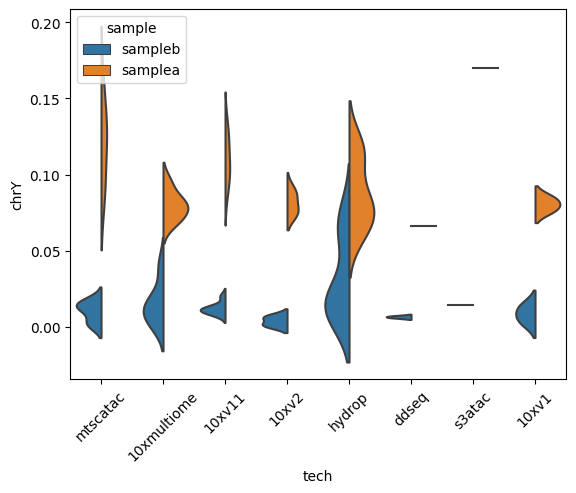

In [69]:
sns.violinplot(df_merged, x="tech", y="chrY", hue="sample", split=True, inner=None)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'mtscatac'),
  Text(1, 0, '10xmultiome'),
  Text(2, 0, '10xv11'),
  Text(3, 0, '10xv2'),
  Text(4, 0, 'hydrop'),
  Text(5, 0, 'ddseq'),
  Text(6, 0, 's3atac'),
  Text(7, 0, '10xv1')])

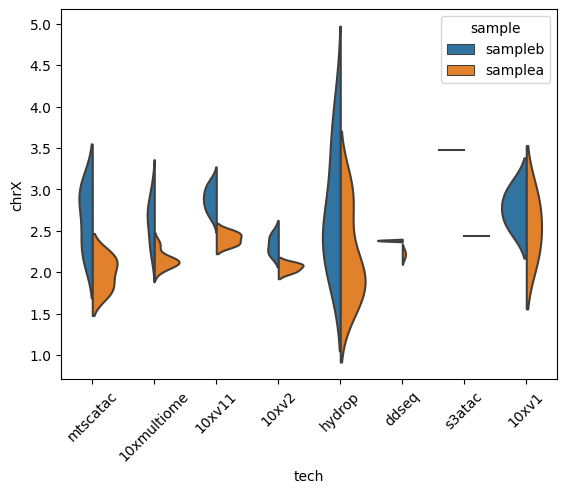

In [70]:
sns.violinplot(df_merged, x="tech", y="chrX", hue="sample", split=True, inner=None)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'mtscatac'),
  Text(1, 0, '10xmultiome'),
  Text(2, 0, '10xv11'),
  Text(3, 0, '10xv2'),
  Text(4, 0, 'hydrop'),
  Text(5, 0, 'ddseq'),
  Text(6, 0, 's3atac'),
  Text(7, 0, '10xv1')])

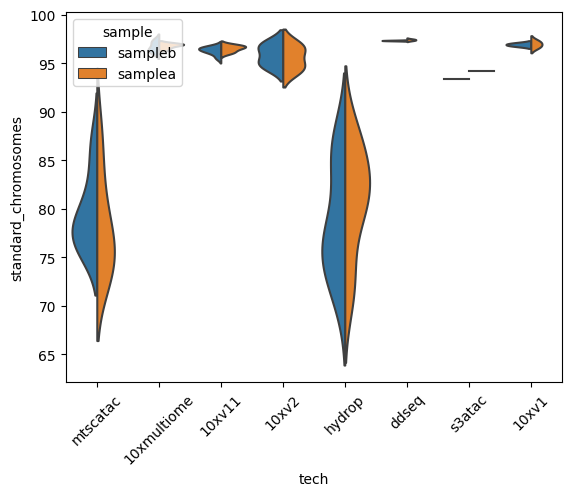

In [72]:
sns.violinplot(
    df_merged, x="tech", y="standard_chromosomes", hue="sample", split=True, inner=None
)
plt.xticks(rotation=45)